In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from tqdm import tqdm, trange, tqdm_notebook

from matplotlib.pylab import get_cmap
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import scipy as sp
import sys, os
import cPickle as pickle
from glob import glob

fs=20
fs_ticks = 16
#sys.path.append('/Users/mhuber/PointSource/skylab/')
#from SkyMap import SkyMap

from scipy.stats import norm

# define sfb colors
colors = ['#3850A1', '#F79645', '#993A91']
#new trial
colors = ['#0D589A', '#5DB5D0', '#A9DBB7','blue']

from matplotlib.ticker import (AutoMinorLocator, FixedLocator, FuncFormatter,
                               MultipleLocator, NullLocator, LogLocator)
import healpy as hp

from scipy.interpolate import UnivariateSpline
from matplotlib.lines import Line2D
from copy import deepcopy

from scipy.interpolate import splrep, splev
from copy import deepcopy 

In [2]:
sys.path.append('../')
from core.tools import *
from core.tools import _trans

In [3]:
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
from PyAstronomy import pyasl

In [4]:
from astropy import units as u
from astropy.coordinates import SkyCoord

# Get the detection efficiency 

<IPython.core.display.Javascript object>


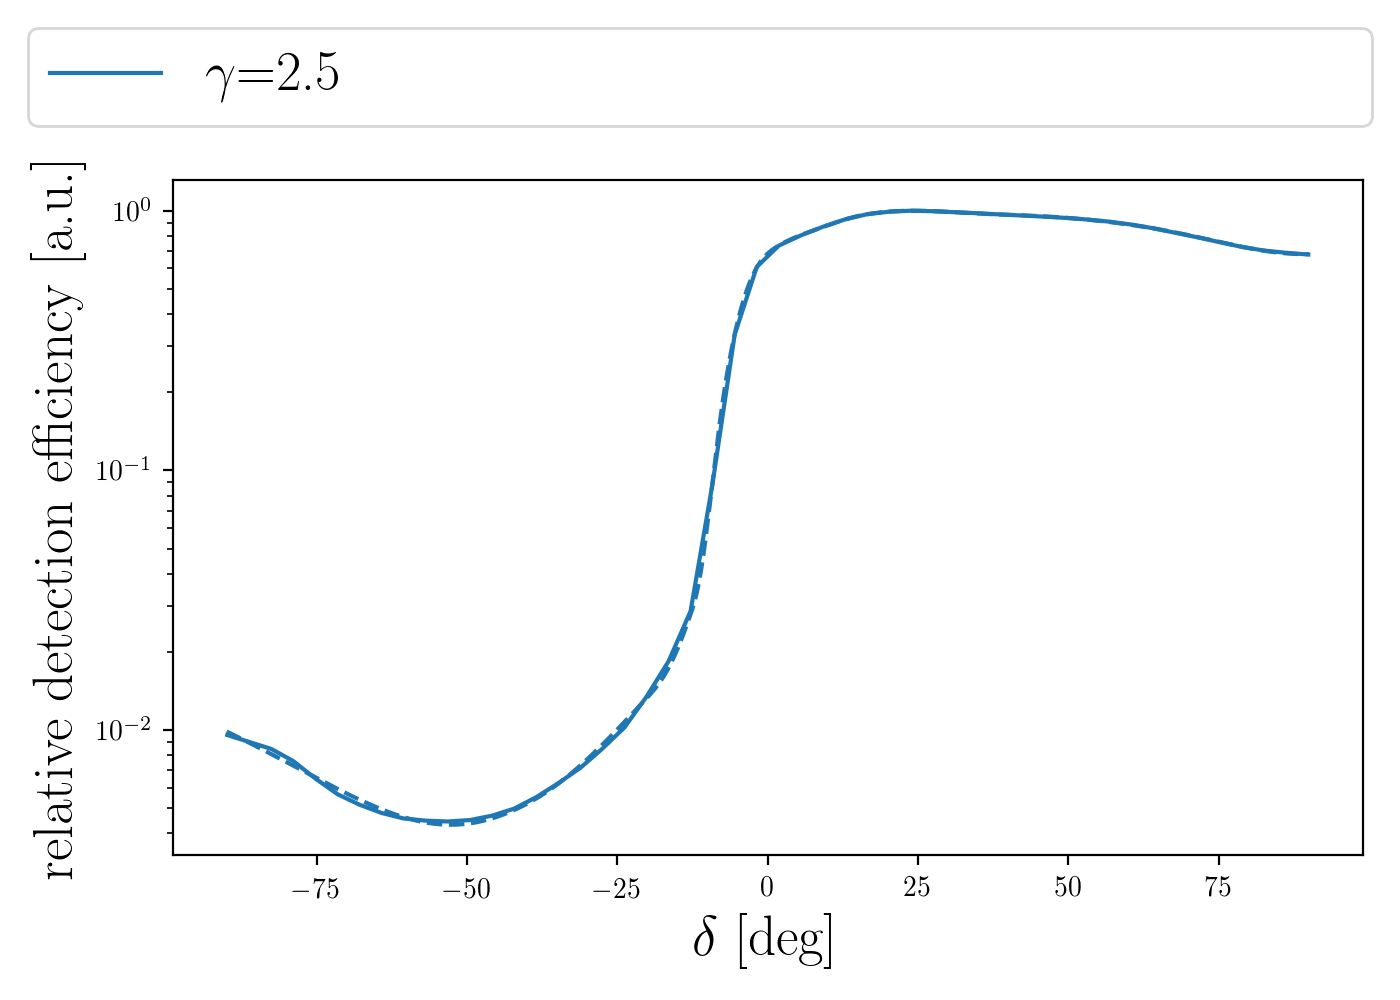

In [5]:
path = "/Users/mhuber/StackingSkylab/MultiYearPointSourceData/"
mc = np.load(os.path.join(path,'IC86-2012_MC.npy'))

ang=4
decs = np.linspace(-np.pi/2+np.radians(0.1), np.pi/2-np.radians(0.1), 50)
xvals = np.linspace(-np.pi/2, np.pi/2, 1000)

fig,ax=plt.subplots(figsize=(7,5))
tcks = dict()
gammas = [2.5]
for gamma in gammas:
    
    Res = np.zeros_like(decs)
    for i, deci in enumerate(decs):
    
        if deci > np.radians(30): ang=10
        dec_min, dec_max = np.sin(deci-np.radians(ang)), np.sin(deci+np.radians(ang))
        Omega = 2 * np.pi * (dec_max - dec_min)
        dec_mask = (np.sin(mc['trueDec']) > dec_min)&(np.sin(mc['trueDec']) < dec_max)

        DetEff = np.sum(mc['ow'][dec_mask] * mc['trueE'][dec_mask]**(-gamma)) / Omega 
        
        


        
        Res[i] = DetEff
    
    Res_max = np.max(Res)
    Res /= np.max(Res)
    
    
    tck = splrep(decs, Res, s=1.e-4)
    spl_val = splev(xvals, tck)
    
    tcks[gamma] = tck
    p=ax.plot(np.degrees(decs), Res, label=r'$\gamma$={0:.1f}'.format(gamma))
    ax.plot(np.degrees(xvals), spl_val, ls='dashed', color=p[0].get_color())
    
fig.legend(loc='upper center', mode='expand', fontsize=fs, ncol=3)
ax.set_xlabel(r'$\delta$ [deg]',fontsize=fs)
ax.set_ylabel(r'relative detection efficiency [a.u.]',fontsize=fs)
ax.set_yscale('log')
fig.tight_layout()

plt.subplots_adjust(top = 0.82)

# Get the plenum improvements by averaging over the earth rotation in right ascension

In [18]:
NSIDE = 2**6
npix = hp.nside2npix(NSIDE)

# this gives the pixel size in sterradian (also called square radian)
psize = hp.nside2pixarea(NSIDE)
print(npix*psize, 4*np.pi)

49152
0.000255663464648
(12.566370614359172, 12.566370614359172)


In [6]:
NSIDE = 2**6
npix = hp.nside2npix(NSIDE)

fact = 1.
poles = {'IceCube':(np.radians(0), np.radians(-90.)),
         'Gen2':(np.radians(0), np.radians(-90.)),
         'P-ONE':(-np.radians(123.3656), np.radians(48.4284)),
         'KM3NeT':(np.radians(16.1), np.radians(36.27)) ,
         'Baikal-GVD':(np.radians(108.1650), np.radians(53.5587)),
         #'X, China':(np.radians(111.918), np.radians(8.640)),
         #'SA, Cape Town ':(np.radians(18.4241), np.radians(-33.9249)),
        #'hypothetical':(np.radians(0.2093), np.radians(-0.8688)),
        }
      
comb_values = dict()

    
for i,(name, new_pole) in enumerate(sorted(poles.iteritems())):    
    
    vals = np.zeros(npix)    
    rot_angles = np.arange(0.,360., 15.) #15.
    for rot_ra in tqdm(rot_angles):
        vals2 = np.zeros(npix)
        new_ra = new_pole[0] + np.radians(rot_ra)
        
        x = np.linspace(0,2*np.pi, 1.e3)
        y = np.linspace(-np.pi/2,np.pi/2 ,500)
    
        xx, yy = np.meshgrid(x,y,indexing='ij')
        
        ra2 , dec2 = rotate(0, -np.pi/2, new_ra, new_pole[1],xx.ravel(),yy.ravel())
        
        
        lat2 = np.pi/2 + dec2
        lat2 = lat2
        lon2, lat2 = _trans(ra2, lat2)
        
        p = hp.ang2pix(NSIDE, lat2, lon2)
        
        if name == 'IceCube' or 'Gen2' in name:
            vals2[p] = splev(yy.ravel(), tck)
        else:
            vals2[p] = splev(yy.ravel(), tck) 
        
        if name == 'Gen2':
            vals2 *= 7.5
    
        vals = vals + vals2 * (1. / len(rot_angles))
    
    comb_values[name] = vals
    
blub = 5000

100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


# Get the values for the 1d (right ascension information is irrelevant due to the earth rotation) discovery potential improvemt with and without Gen2

first get the current values for sens and disc pot


<IPython.core.display.Javascript object>


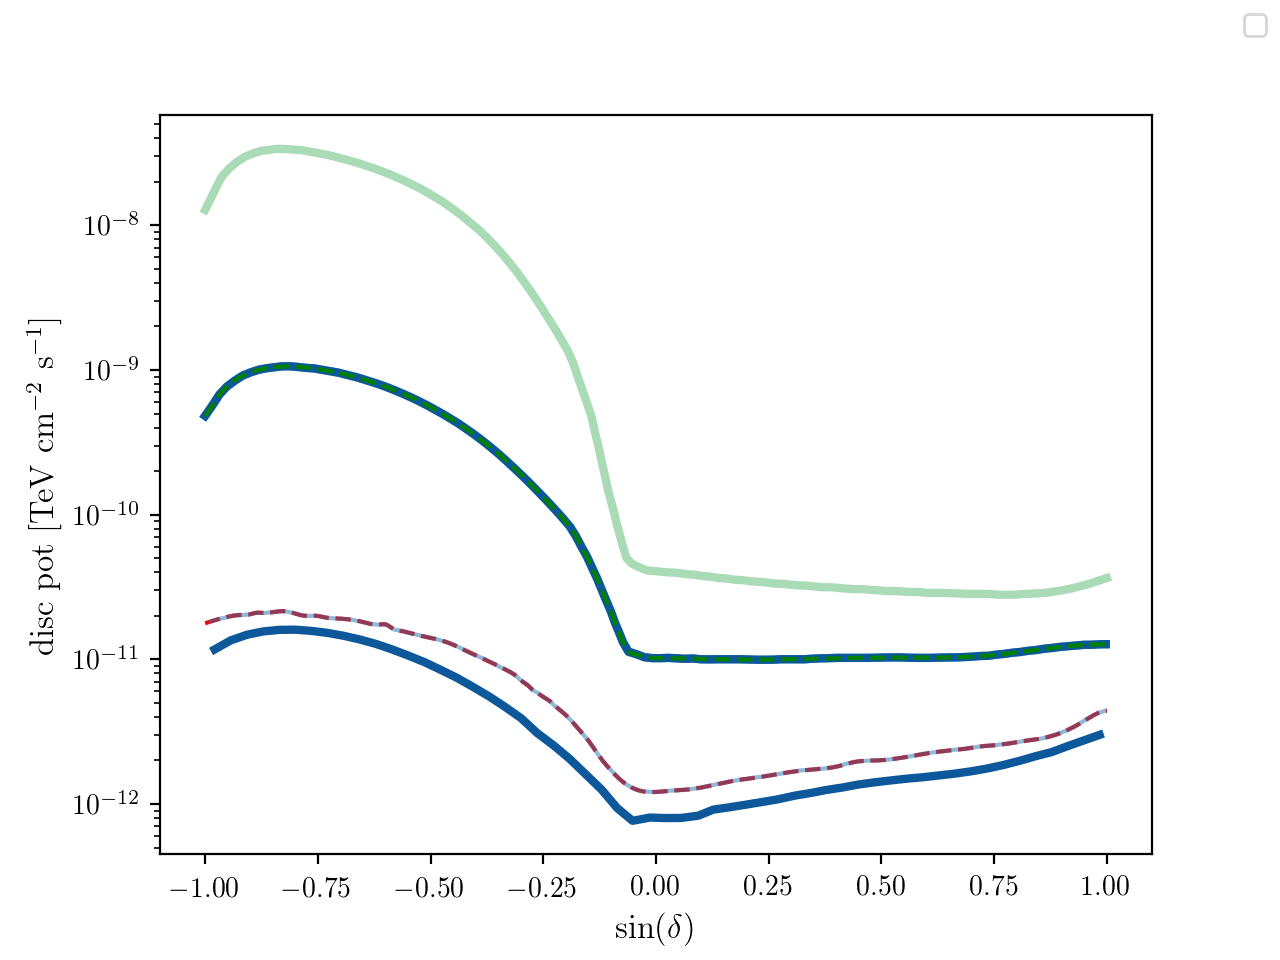

(2.5, 2.5)


In [7]:
disc = np.genfromtxt('resources/PSdiscPot7years.csv', delimiter=',')
sdec = disc[:,0]
disc = disc[:,1]

tck_disc = splrep(sdec, np.log(disc), s=1.e-3)
xvals = np.linspace(-1, 1, 1000)
spl_disc = splev(xvals, tck_disc)

fig,ax=plt.subplots()

ax.plot(xvals,np.exp(spl_disc), color='red', ls='dashed')
ax.plot(sdec, disc, alpha=0.5)
    
fig.legend()
ax.set_xlabel(r'$\sin(\delta)$',fontsize=12)
ax.set_ylabel(r'disc pot [TeV cm$^{-2}$ s$^{-1}$]',fontsize=12)
ax.set_yscale('log')


ps_disc = np.genfromtxt('resources/'+
                        'tcarver_10y_disc.csv', delimiter=',')
ind_disc = np.argsort(ps_disc[:,0])
ax.plot(ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', color=colors[0],lw=3,
       label='2')


ps_disc = np.genfromtxt('resources/'+
                        '10yr_ps_dicPot_g25_tessaThesis.csv', delimiter=',')
ind_disc = np.argsort(ps_disc[:,0])
ax.plot(ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', color=colors[1],lw=3,
       label='2.5')

ps_disc = np.genfromtxt('resources/'+
                        '10yr_ps_dicPot_g3_tessaThesis.csv', delimiter=',')
ind_disc = np.argsort(ps_disc[:,0])
ax.plot(ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', color=colors[2], lw=3,
       label='3')

if gammas[0] == 2:
    print(gammas[0],gamma)
    ps_disc = np.genfromtxt('resources/'+
                        'tcarver_10y_disc.csv', delimiter=',')

elif gammas[0] ==2.5:
    print(gammas[0],gamma)
    ps_disc = np.genfromtxt('resources/'+
                        '10yr_ps_dicPot_g25_tessaThesis.csv', delimiter=',')

elif gammas[0] ==3.:
    print(gammas[0],gamma)
    ps_disc = np.genfromtxt('resources/'+
                        '10yr_ps_dicPot_g3_tessaThesis.csv', delimiter=',')




ind_disc = np.argsort(ps_disc[:,0])
ax.plot(ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', color=colors[0],lw=3,
       label='IceCube PS 5$\sigma$ Disc. Potential')

tck_disc = splrep(ps_disc[:,0][ind_disc], np.log(ps_disc[:,1][ind_disc]), s=1.e-3)
xvals = np.linspace(-1, 1, 1000)
spl_disc = splev(xvals, tck_disc)

ax.plot(xvals,np.exp(spl_disc), color='green', ls='dashed')

In [8]:
#------------------------------------------
# cover area at the horizon that is not 
# plotted nicely
#------------------------------------------

num = 5000
x = np.linspace(0,2*np.pi, num)
y = np.linspace(-np.pi/2,np.pi/2 ,500)

disc_vals = np.ones(npix)
for dec_i in y:
    
    #get the pixels
    p = hp.ang2pix(NSIDE, dec_i+np.pi/2, x)
    #fill them 
    disc_vals[p] = np.exp(splev(np.sin(dec_i), tck_disc))


disc_ice = np.min(disc_vals)

<IPython.core.display.Javascript object>


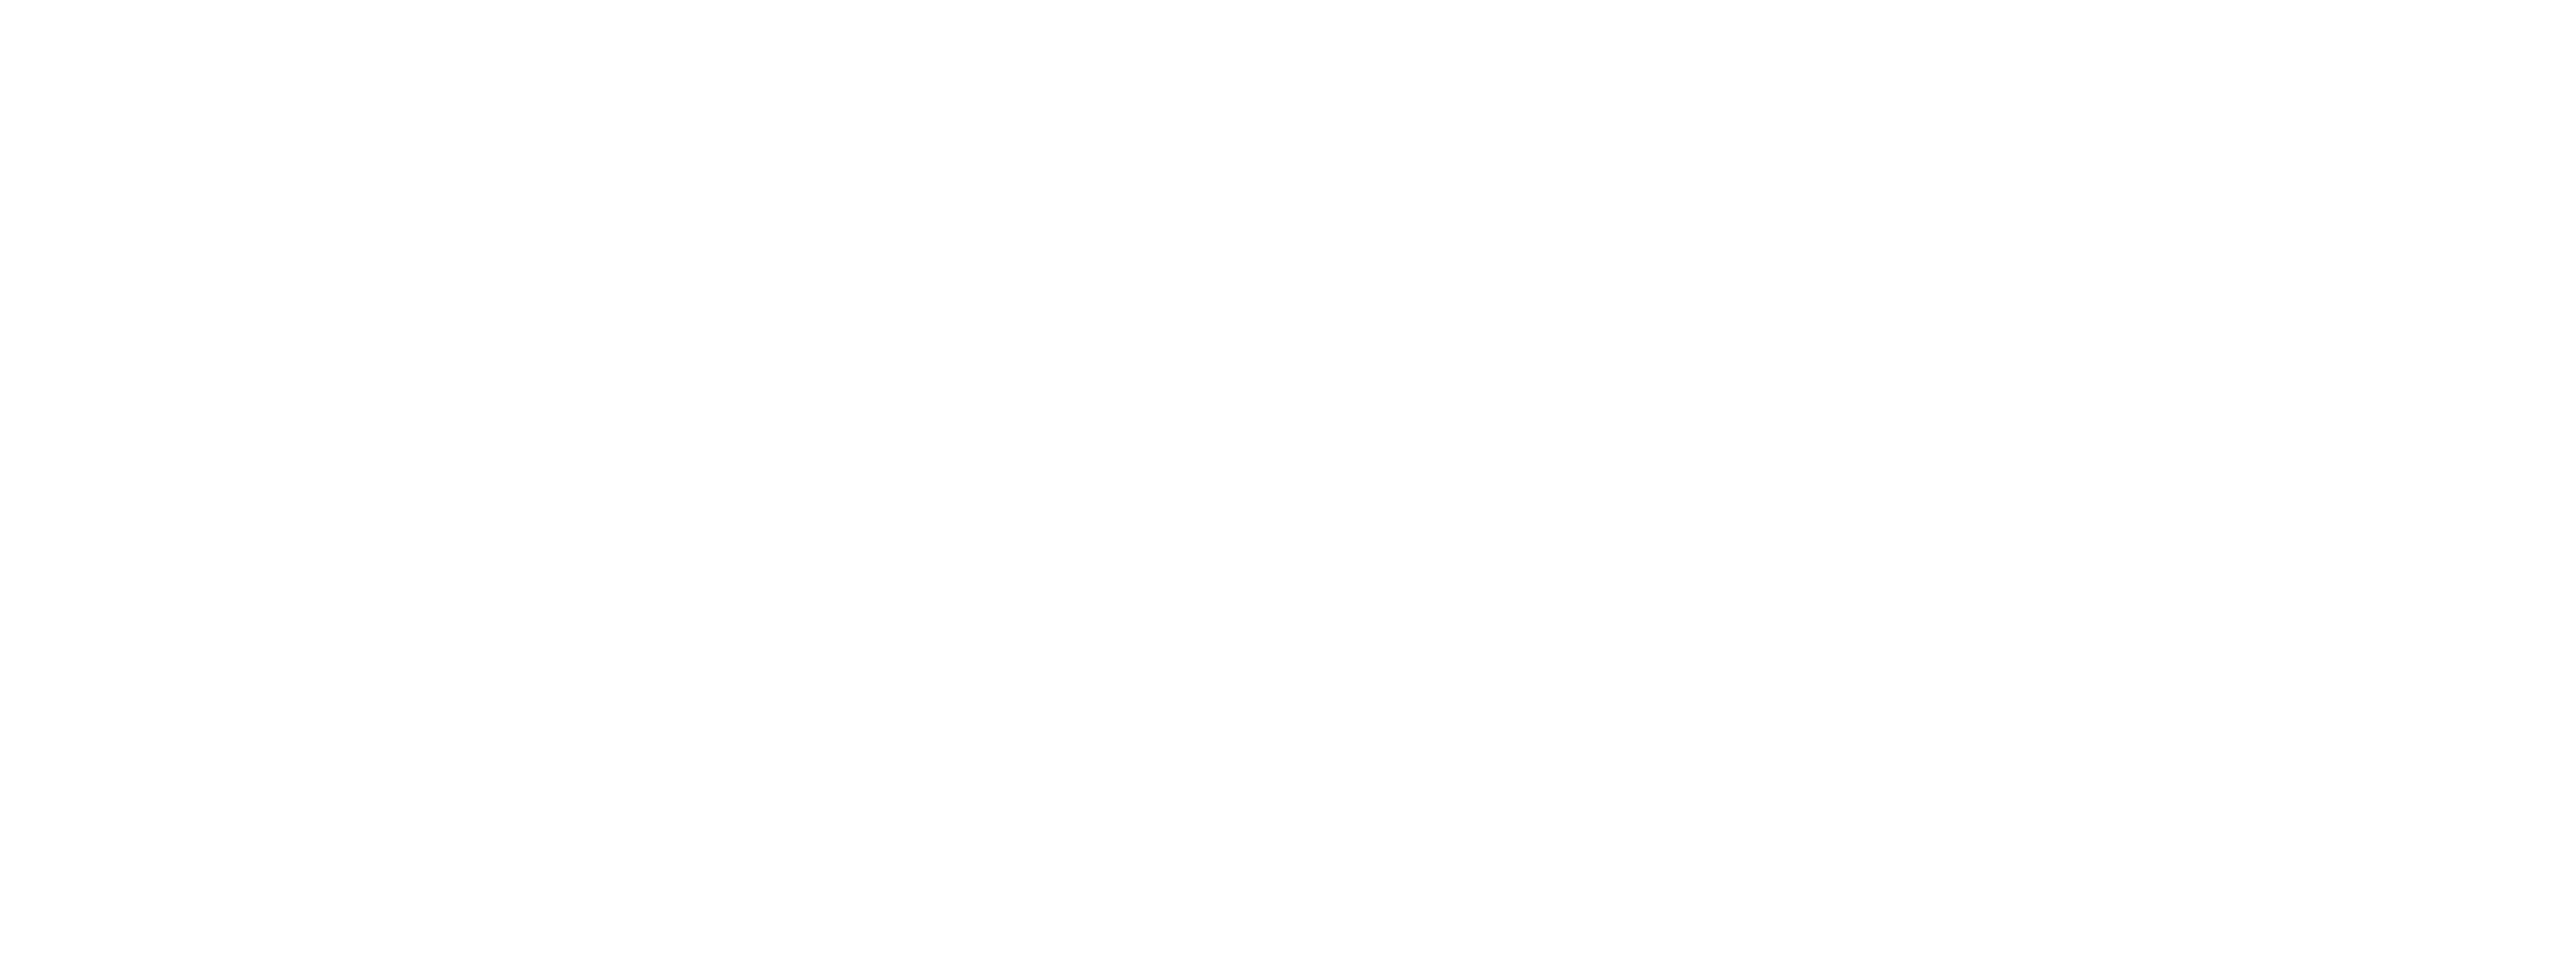

(2.9393668488168284e-12, 7.224683123974168e-12)


In [9]:
ngrid=500

t_0 = 10. # years
t_new = 10. # years

vari = 'rrel'
used_keys = list()
fact = 1.


fig =  plt.figure(figsize=(16,6))
    
bckg_vals2 = deepcopy(comb_values['IceCube'])
all_vals = deepcopy(comb_values)

#-------------------------------------------    
# Show the improvements with Gen2 as well   
#-------------------------------------------

comb_vals = np.zeros(npix)
ax= fig.add_subplot(121, projection='hammer',
                                       rasterized=True)
    
for (name, vali) in sorted(all_vals.iteritems()):
    if vari == 'rrel':
        mask_bckg = bckg_vals2 > 0.0
        vali[mask_bckg] /= bckg_vals2[mask_bckg]
        vali[~mask_bckg] = np.max(vali[mask_bckg])


    nuse = ['X, China']


    if name == 'IceCube' and 'Gen2' in nuse:
        comb_vals += (t_0+t_new) * vali
    elif name == 'IceCube':
        comb_vals += t_0 * vali
    elif name in nuse:
        continue
    else:
        comb_vals += t_new * vali * fact

    if name not in used_keys:
        used_keys.append(name)

effA_vals_wGen2 = deepcopy(comb_vals)

new_vals = (comb_vals / (t_0+t_new))**(-0.8)
mask0 = new_vals > 0.
new_vals[mask0] = new_vals[mask0]
new_vals[~mask0] = np.min(new_vals[mask0])


disci = disc_vals * 1./ ( (t_0+t_new)/ 10.)**0.8
new_vals *= disci

_min = np.min(new_vals)
_max = np.max(new_vals)

cax=plot_area(new_vals, ax, npix=ngrid,  alpha=1., vmax=_max,  vmin=_min, #.e14, #vmax=1.,
         shading='gouraud', cmap='GnBu_r')#, norm=LogNorm())

cax_effA_wGen2 = plot_area(effA_vals_wGen2, ax, npix=ngrid,  alpha=1., vmax=_max,  vmin=_min, #.e14, #vmax=1.,
         shading='gouraud', cmap='GnBu_r')


#-------------------------------------------    
# Show the improvements with Gen2 as well   
#-------------------------------------------
bckg_vals2 = deepcopy(comb_values['IceCube'])
all_vals = deepcopy(comb_values)

used_keys2 = list()
comb_vals2 = np.zeros(npix)
ax= fig.add_subplot(122, projection='hammer',
                                       rasterized=True)
    
for (name, vali) in sorted(all_vals.iteritems()):
    if vari == 'rrel':
        mask_bckg = bckg_vals2 > 0.0
        vali[mask_bckg] /= bckg_vals2[mask_bckg]
        vali[~mask_bckg] = np.max(vali[mask_bckg])


    nuse = ['X, China', 'Gen2']


    if name == 'IceCube' and 'Gen2' in nuse:
        comb_vals2 += (t_0+t_new) * vali
    elif name == 'IceCube':
        comb_vals2 += t_0 * vali
    elif name in nuse:
        continue
    else:
        comb_vals2 += t_new * vali * fact

    if name not in used_keys2:
        used_keys2.append(name)

        
effA_vals_woGen2 = deepcopy(comb_vals2)
new_vals2 = (comb_vals2 / (t_0+t_new))**(-0.8)
mask0 = new_vals2 > 0.
new_vals2[mask0] = new_vals2[mask0]
new_vals2[~mask0] = np.min(new_vals2[mask0])


disci = disc_vals * 1./ ( (t_0+t_new)/ 10.)**0.8
new_vals2 *= disci


rvals = new_vals2

_min = np.min(rvals)
_max = np.max(rvals)

print(_min, _max)
cax2=plot_area(rvals, ax, npix=ngrid,  alpha=1., vmax=_max,  vmin=_min, #.e14, #vmax=1.,
         shading='gouraud', cmap='GnBu_r')#, norm=LogNorm())

cax_effA_woGen2 = plot_area(effA_vals_woGen2, ax, npix=ngrid,  alpha=1., vmax=_max,  vmin=_min, #.e14, #vmax=1.,
         shading='gouraud', cmap='GnBu_r')
plt.close()
   

(10.0, 10.0)


<IPython.core.display.Javascript object>


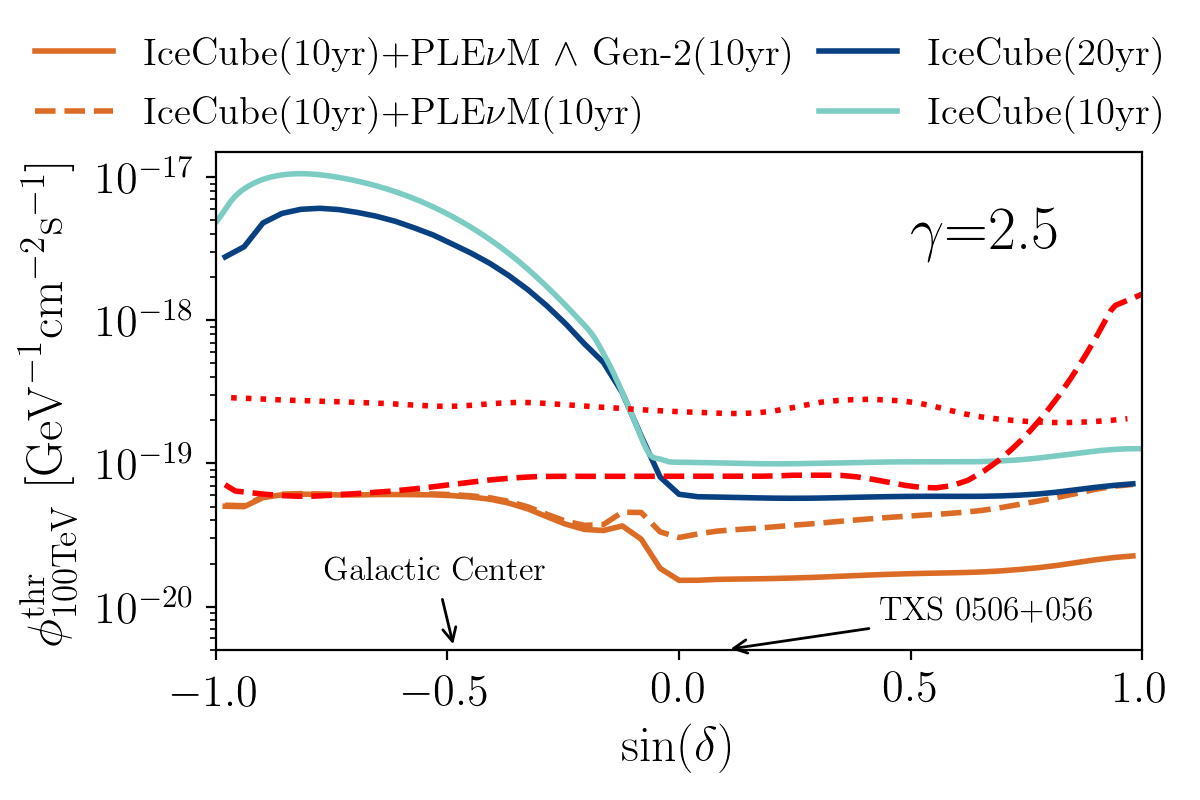

In [10]:
# get the results from PLENUM(+Gen2)
z = cax.get_array()
z2 = cax2.get_array()


z_effA1 = cax_effA_woGen2.get_array()

# get the icecube results
print(t_0, t_new)
t_newi = t_new
disci = disc_vals * 1./ ( (t_0+t_newi)/ 10)**0.8
cax3=plot_area(disci, ax, npix=ngrid,  alpha=1., #vmin=1.e14, #vmax=1.,
             shading='gouraud', cmap='GnBu_r', norm=LogNorm())

z_icecube = cax3.get_array()

# get the cordinates of the skymap entries
x = np.linspace(-np.pi, np.pi, ngrid)
y = np.linspace( 0, np.pi, ngrid / 2)
       
lon = np.linspace(-np.pi, np.pi, len(x))
lat = np.linspace(-np.pi/2., np.pi/2., len(y))

xx,yy = np.meshgrid(lon,lat)

bins = np.linspace(-1,1, 50) #50
res_wGen2 = np.zeros_like(get_mids(bins))
res_woGen2 = np.zeros_like(get_mids(bins))
res_ice = np.zeros_like(get_mids(bins))
_effA_woGen2 = np.zeros_like(get_mids(bins))


inds = np.searchsorted( bins, np.sin(yy.flatten()))



for i, indi in enumerate(get_mids(bins)):
    m = inds==i
    res_wGen2[i] = np.sum(z[m]) / float(np.sum(m))
    res_woGen2[i] = np.sum(z2[m]) / float(np.sum(m))
    res_ice[i] = np.sum(z_icecube[m]) / float(np.sum(m))
    _effA_woGen2[i] = np.sum(z_effA1[m]) / float(np.sum(m))



fig,ax = plt.subplots(figsize=(6,4))

gcm = get_cmap('GnBu_r')
num_c = 2 + 2
cgen = [gcm(th/float(num_c)) for th in range(num_c)]


# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 10**(-2*gamma) / 1.e3


c='#DC6C25'
p=ax.plot(get_mids(bins), res_wGen2*const, label=r'IceCube(10yr)+PLE$\nu$M $\wedge$ Gen-2(10yr)',
       lw=2., color=c)
ax.plot(get_mids(bins), res_woGen2*const, label=r'IceCube(10yr)+PLE$\nu$M(10yr)', lw=2.,
       color=p[0].get_color(), ls='dashed')

ax.plot(get_mids(bins), res_ice*const, color=cgen[0], label=r'IceCube(20yr)', lw=2.)
ax.plot(xvals,np.exp(spl_disc)*const, color=cgen[2], ls='solid', label=r'IceCube(10yr)',
       lw=2.)

ax.set_yscale('log')

ax.set_xlim(-1,1)
ax.set_xlabel(r"$\sin(\delta)$",fontsize=fs-2)

fig.legend( fontsize=fs-6, loc='best', mode='expand',
            ncol=2, frameon=False)
ax.text(0.75,0.8, r'$\gamma$={0:.1f}'.format(gamma), fontsize=22 ,
         transform = ax.transAxes)

if gamma==2:
    ax.set_ylabel(r"$\phi^{\mathrm{thr}}_{100\mathrm{TeV}}$  [$\mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1}$]",
              fontsize=fs-2)
    
    ax.tick_params(axis='both', which='major', labelsize=fs-4)
    ax.set_ylim(5e-21, 1.5e-17) 
    # add the location of the galactic center and TXS
    ax.annotate("Galactic Center", xy=(np.sin(np.radians(-29.)), 5.e-21), xytext=(np.sin(np.radians(-50.)), 15.e-21),
            arrowprops=dict(arrowstyle="->"), fontsize=12)

    ax.annotate("TXS 0506+056", xy=(np.sin(np.radians(5.7)), 5.e-21), xytext=(np.sin(np.radians(25.7)), 8.e-21),
            arrowprops=dict(arrowstyle="->"), fontsize=12)

elif gamma==2.5:
    ax.set_ylabel(r"$\phi^{\mathrm{thr}}_{100\mathrm{TeV}}$  [$\mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1}$]",
              fontsize=fs-2)
    
    ax.tick_params(axis='both', which='major', labelsize=fs-4)
    ax.set_ylim(5e-21, 1.5e-17) 
    # add the location of the galactic center and TXS
    ax.annotate("Galactic Center", xy=(np.sin(np.radians(-29.)), 5.e-21), xytext=(np.sin(np.radians(-50.)), 15.e-21),
            arrowprops=dict(arrowstyle="->"), fontsize=12)

    ax.annotate("TXS 0506+056", xy=(np.sin(np.radians(5.7)), 5.e-21), xytext=(np.sin(np.radians(25.7)), 8.e-21),
            arrowprops=dict(arrowstyle="->"), fontsize=12)

    
km3net_cas = np.genfromtxt('/Users/mhuber/Documents/Km3NET_cascade_discPot_3years.csv', 
                           delimiter=',')

ax.plot(km3net_cas[:,0], km3net_cas[:,1]*1e-10 * (10/3.)**(-0.8), color='red', lw=2.,
       ls='dotted')

km3net_cas = np.genfromtxt('/Users/mhuber/Documents/Km3NET_track_discPot_3years.csv', 
                           delimiter=',')

ax.plot(km3net_cas[:,0], km3net_cas[:,1]*1e-10 * (10/3.)**(-0.8), color='red', lw=2.,
       ls='dashed')
    
    
fig.tight_layout()

plt.subplots_adjust(top = 0.81)
#fig.savefig('plots/PLENUM_ps_disc_pot_time_evolution_g2_pCascades.pdf',
#               bbox_inches="tight")

# Now do a similar plot but with the time on the x-axis


<IPython.core.display.Javascript object>


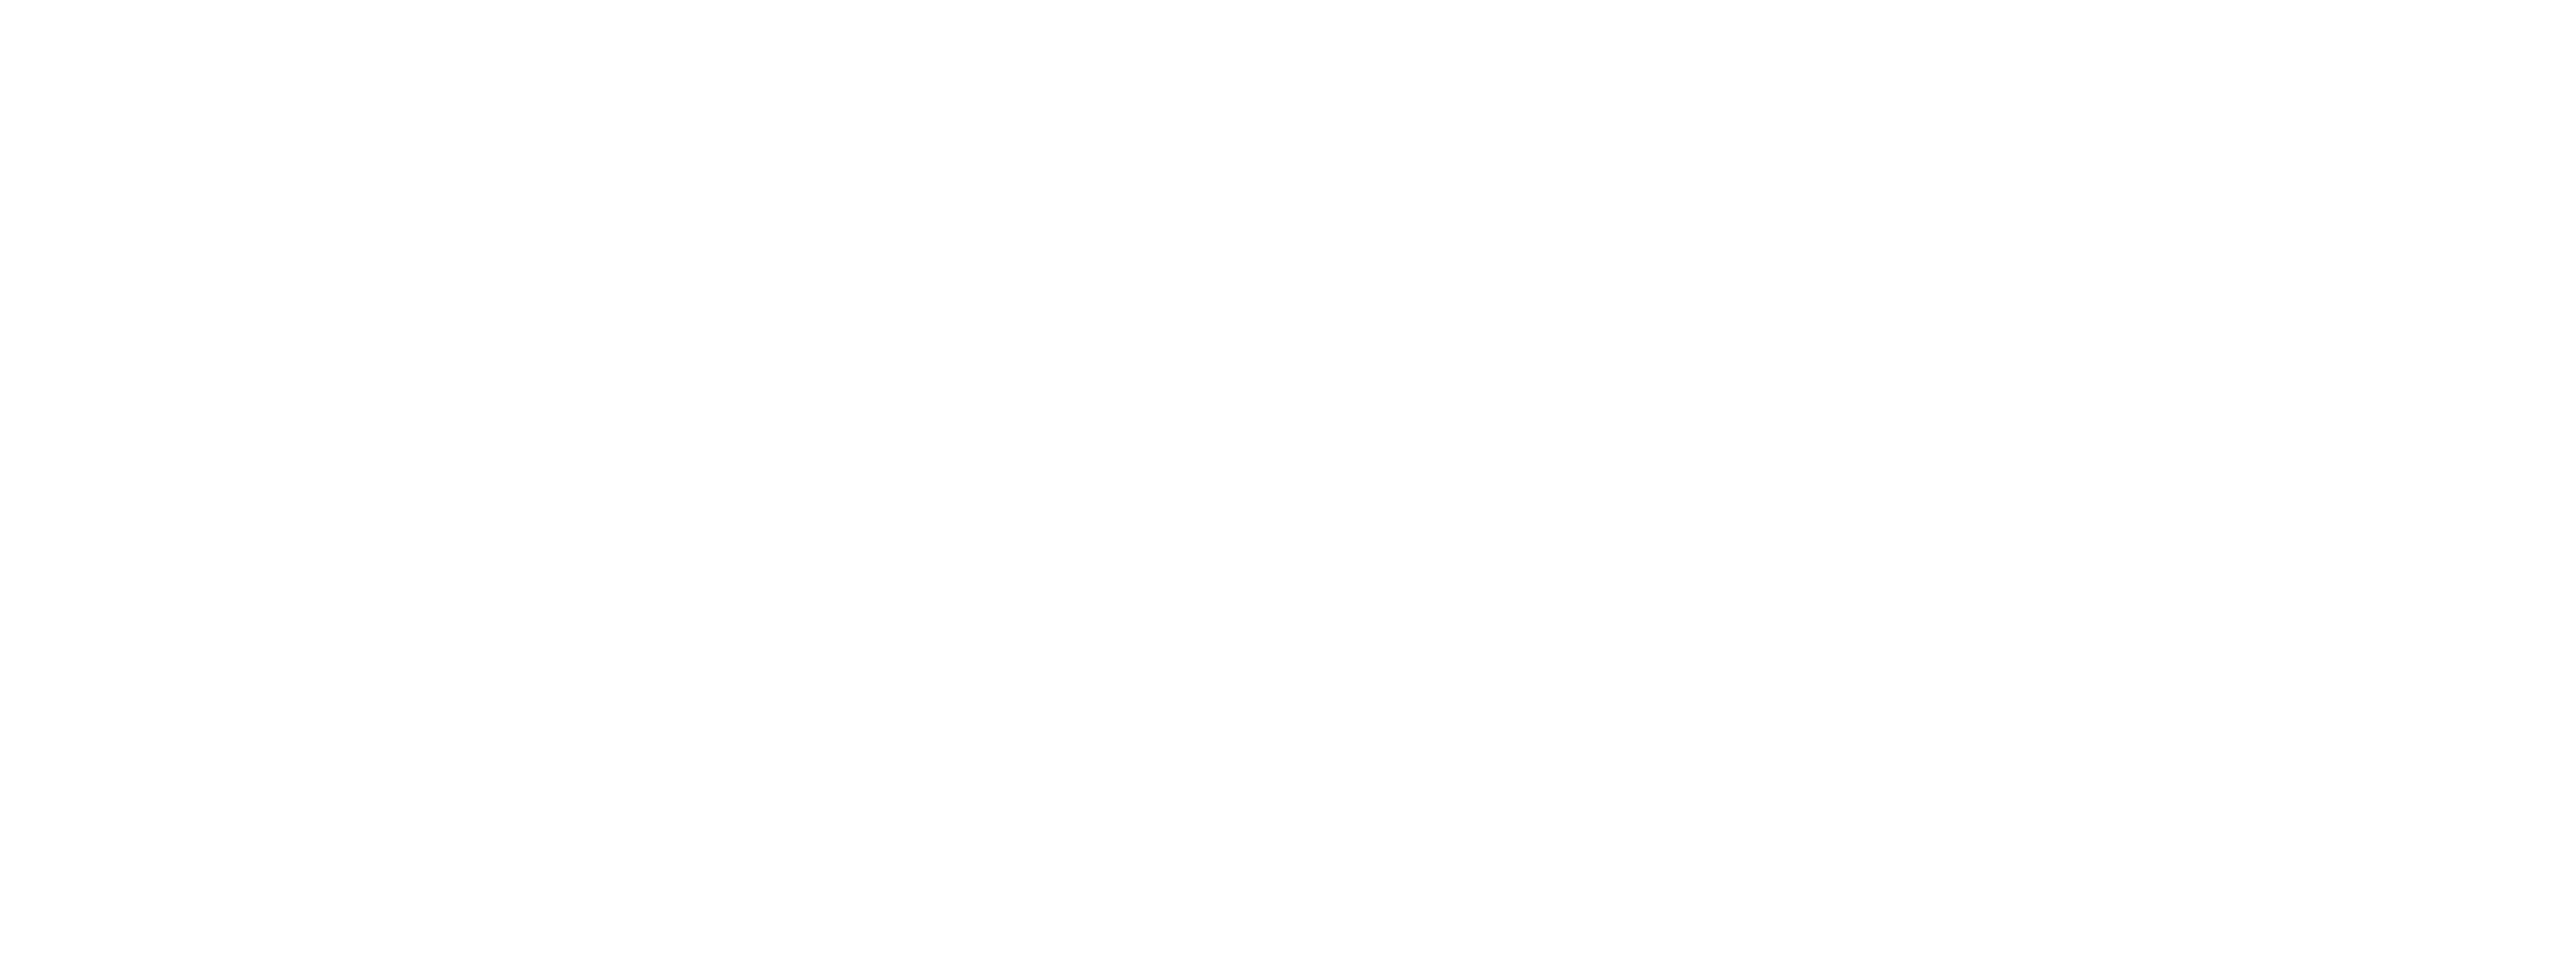

In [11]:
t_0 = 10. # years
#t_new = 10. # years
t_news = np.arange(0,15,.25)

vari = 'rrel'
used_keys = list()
fact = 1.


fig =  plt.figure(figsize=(16,6))
    
results = dict()
scenarios = {'p_woGen2':['Gen2'], 'p_wGen2':[] }
bins = np.linspace(-1,1, 50) #50 declination bins in sin(dec)

for key, sceni in scenarios.items():
    if not key in results.keys():
        results[key] = dict()
        
    for t_new in t_news:
        bckg_vals2 = deepcopy(comb_values['IceCube'])
        all_vals = deepcopy(comb_values)

        #-------------------------------------------    
        # Show the improvements with Gen2 as well   
        #-------------------------------------------

        comb_vals = np.zeros(npix)
        ax= fig.add_subplot(121, projection='hammer',
                                           rasterized=True)

        for (name, vali) in sorted(all_vals.iteritems()):
            if vari == 'rrel':
                mask_bckg = bckg_vals2 > 0.0
                vali[mask_bckg] /= bckg_vals2[mask_bckg]
                vali[~mask_bckg] = np.max(vali[mask_bckg])


            nuse = ['X, China']+sceni


            if name == 'IceCube' and 'Gen2' in nuse:
                comb_vals += (t_0+t_new) * vali
            elif name == 'IceCube':
                comb_vals += t_0 * vali
            elif name in nuse:
                continue
            else:
                comb_vals += t_new * vali * fact

            if name not in used_keys:
                used_keys.append(name)



        new_vals = (comb_vals / (t_0+t_new))**(-0.8)
        mask0 = new_vals > 0.
        new_vals[mask0] = new_vals[mask0]
        new_vals[~mask0] = np.min(new_vals[mask0])


        disci = disc_vals * 1./ ( (t_0+t_new)/ 10.)**0.8
        new_vals *= disci

        _min = np.min(new_vals)
        _max = np.max(new_vals)

        cax=plot_area(new_vals, ax, npix=ngrid,  alpha=1., vmax=_max,  vmin=_min, #.e14, #vmax=1.,
                 shading='gouraud', cmap='GnBu_r')#, norm=LogNorm())

        # get the results from PLENUM(+Gen2)
        z = cax.get_array()

        # get the cordinates of the skymap entries
        x = np.linspace(-np.pi, np.pi, ngrid)
        y = np.linspace( 0, np.pi, ngrid / 2)

        lon = np.linspace(-np.pi, np.pi, len(x))
        lat = np.linspace(-np.pi/2., np.pi/2., len(y))

        xx,yy = np.meshgrid(lon,lat)

        
        res = np.zeros_like(get_mids(bins))
        inds = np.searchsorted( bins, np.sin(yy.flatten()))

        # get average values at each declination bin
        for i, indi in enumerate(get_mids(bins)):
            m = inds==i
            res[i] = np.sum(z[m]) / float(np.sum(m))

        
        results[key][t_new] = res
    
results['icecube'] = dict()
for t_new in t_news:        
        
    disci = disc_vals * 1./ ( (t_0+t_new)/ 10)**0.8
    cax=plot_area(disci, ax, npix=ngrid,  alpha=1., #vmin=1.e14, #vmax=1.,
             shading='gouraud', cmap='GnBu_r', norm=LogNorm())

    z_icecube = cax.get_array()        
    
    res = np.zeros_like(get_mids(bins))
    inds = np.searchsorted( bins, np.sin(yy.flatten()))

    # get average values at each declination bin
    for i, indi in enumerate(get_mids(bins)):
        m = inds==i
        res[i] = np.sum(z_icecube[m]) / float(np.sum(m))
    
    results['icecube'][t_new] = res
    
plt.close()



In [12]:
results5_10 = dict()
t_old = np.arange(-5,0,0.25)

for t_new in t_old:        
        
    disci = disc_vals * 1./ ( (t_0+t_new)/ 10)**0.8
    cax=plot_area(disci, ax, npix=ngrid,  alpha=1., #vmin=1.e14, #vmax=1.,
             shading='gouraud', cmap='GnBu_r', norm=LogNorm())

    z_icecube = cax.get_array()        
    
    res = np.zeros_like(get_mids(bins))
    inds = np.searchsorted( bins, np.sin(yy.flatten()))

    # get average values at each declination bin
    for i, indi in enumerate(get_mids(bins)):
        m = inds==i
        res[i] = np.sum(z_icecube[m]) / float(np.sum(m))
    
    results5_10[t_new] = res

<IPython.core.display.Javascript object>


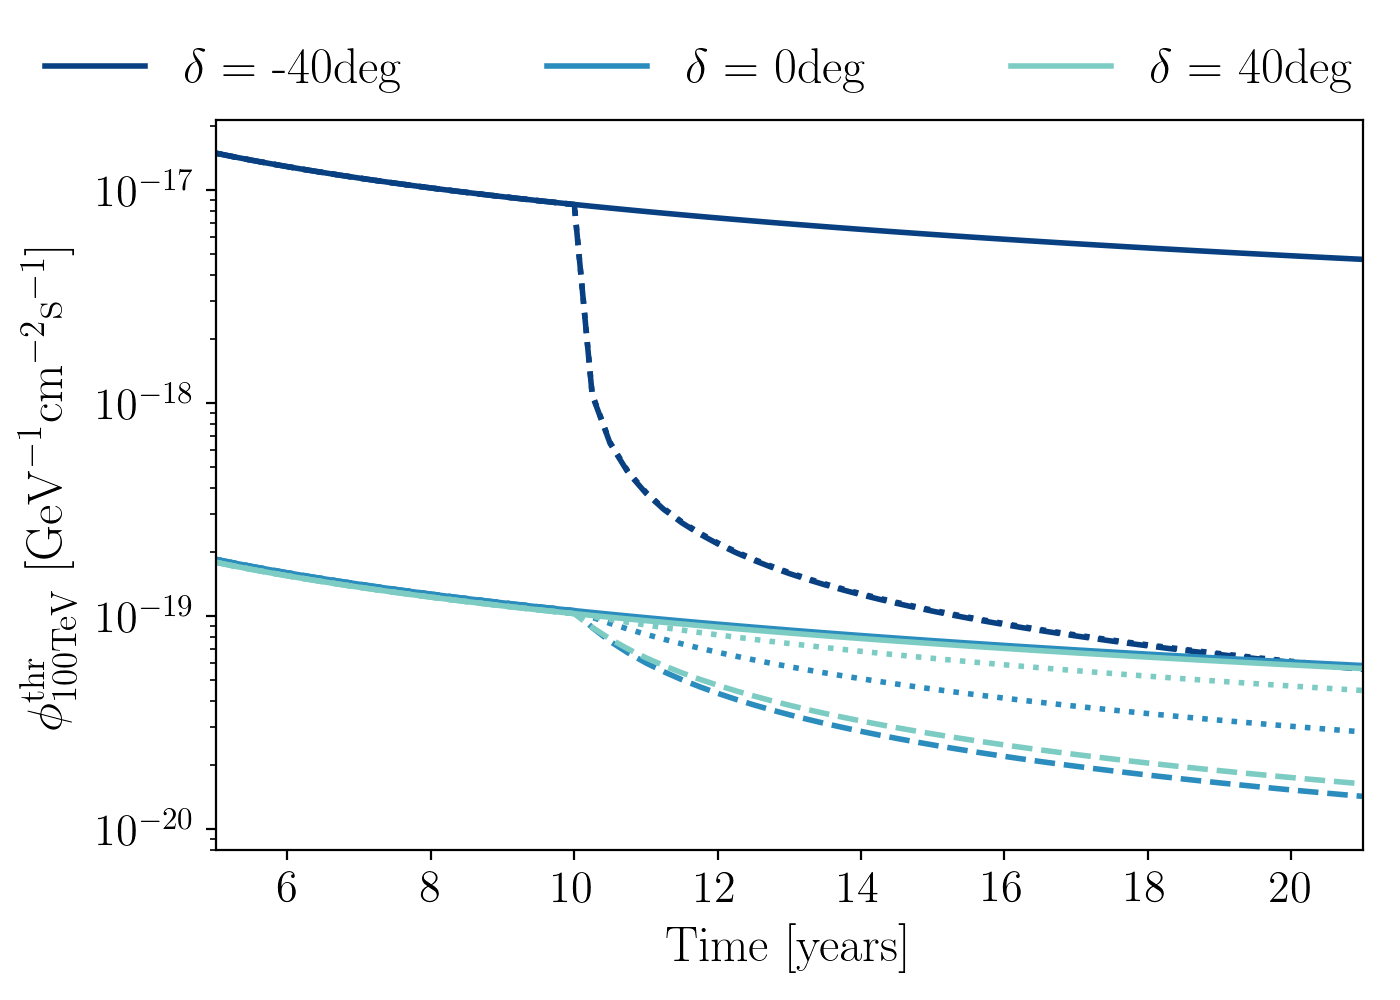

In [13]:
fig,ax = plt.subplots(figsize=(7,5))
lss = {'icecube':'solid', 'p_woGen2':'dotted', 'p_wGen2':'dashed' }

decs = [-40, 0 ,40]
gcm = get_cmap('GnBu_r')
num_c = 2 + 2
cgen = [gcm(th/float(num_c)) for th in range(num_c)]



for i,dec in enumerate(decs):
    
    ind_dec = np.argmin(np.abs(bins-np.sin(np.deg2rad(dec))))
    # conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
    const = 10**(-2*gamma) / 1.e3


    results_time = dict()
    for key, resi in results.items():
        res_time = np.zeros_like(t_news, dtype=float)
        for k, (key1, res1) in enumerate(sorted(resi.items())):
            res_time[k] = res1[ind_dec]

        results_time[key] = res_time

    res_time_old = np.zeros_like(t_old, dtype=float)
    for k, (key1, res1) in enumerate(sorted(results5_10.items())):
        res_time_old[k] = res1[ind_dec]


    #ax.plot(t_old,res_time_old*const , lw=2)  

    
    for key, resi in results_time.items():

        if key == 'icecube': 
            ax.plot(np.concatenate([t_old,t_news])+10, np.concatenate([res_time_old,resi])*const, 
                label=r'$\delta$ = {0:.0f}deg'.format(dec),
               lw=2., color=cgen[i] , ls = lss[key])
        else:
            ax.plot(np.concatenate([t_old,t_news])+10, np.concatenate([res_time_old,resi])*const, 
               lw=2., color=cgen[i] , ls = lss[key])
        
        

ax.set_yscale('log')
ax.set_xlabel(r"Time [years]",fontsize=fs-2)
ax.set_ylabel(r"$\phi^{\mathrm{thr}}_{100\mathrm{TeV}}$  [$\mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1}$]",
              fontsize=fs-2)
    
ax.tick_params(axis='both', which='major', labelsize=fs-4)

fig.legend( fontsize=fs-2, loc='upper center', mode='expand',
            ncol=3, frameon=False)

ax.set_xlim(5,21)
if gammas[0] ==2.:
    ax.set_ylim(8e-21,5e-18)
elif gammas[0] ==2.:
    ax.set_ylim(3e-21,5e-17)
#else:
#    ax.set_ylim(3e-18,5e-15)

fig.tight_layout()

plt.subplots_adjust(top = 0.88)
fig.savefig('plots/PLENUM_ps_disc_pot_time_evolution_v2_{0:.1f}.pdf'.format(gammas[0]),
               bbox_inches="tight")
